# Modelo Baseline de la Demanda Eléctrica

## Objetivo
El objetivo de este notebook es desarrollar un modelo de predicción de la
demanda eléctrica básico que permita generar proyecciones
hasta el año 2026. Este modelo servirá para comparar el rendimiento del modelo de series temporales posterior y analizar su mejoría.

Por tanto, en este modelo usaremos dos años y la tendencia anual exclsuivamente, para relaizar el test y train.

## Carga de datos y librerías

In [ ]:
import pandas as pd
import numpy as np
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

In [ ]:
# Si usas colab usar este scrip
df = pd.read_csv("/content/SET_INPUTS_BASE_0.csv", sep=";")
df.head()

,Year,Month,Day,DayOfYear,Demanda_GWh,Gen_Eolica_GWh,Gen_Solar_GWh,Pot_Eolica_GW,Pot_Solar_GW,Price_Elec_EUR_MWh,Temp_min_C_Nat,Temp_max_C_Nat,Temp_media_C_Nat,RadiacionGlobal_media_Wm2_Nat,Viento_media_ms_Nat,Price_Gas_EUR_MWh
0,2019,1,1,1,"547,404192","77,680013","25,58687","21,3969275","6,447067088","63,45458333","1,075316934","12,75559495","6,323518858","119,9719996","1,350332275","27,17"
1,2019,1,2,2,"701,784804","194,507772","25,453782","21,3969275","6,447067088","61,58541667","0,693947211","10,85852004","4,87310807","106,5043194","1,953407725","24,5"
2,2019,1,3,3,"746,345169","109,405705","22,307852","21,3969275","6,447067088","63,96166667","-0,831520694","10,12816949","3,880210679","106,2649415","1,495342364","24,76"
3,2019,1,4,4,"754,085459","79,098774","23,624898","21,3969275","6,447067088","66,83583333","-0,770384986","10,17460942","3,891902936","114,4084482","1,329866183","24,94"
4,2019,1,5,5,"681,461272","116,074127","25,952103","21,3969275","6,447067088","65,32875","-0,826576318","11,23432552","4,089401168","116,9314194","1,626659952","25,58"


In [ ]:
# Si usas VSC u otro usar este scrip
# df = pd.read_csv("Poner tu ruta del archivo aquí")
# df.head()

## Preparación de la serie temporal

Se construye la variable temporal `ds` y se elimina el 29 de febrero
para trabajar con años homogéneos de 365 días, práctica habitual
en estudios de demanda eléctrica.

In [ ]:
df["ds"] = pd.to_datetime(df[["Year", "Month", "Day"]])

df = df[~((df["ds"].dt.month == 2) & (df["ds"].dt.day == 29))].copy()

df_prophet = df[["ds", "Demanda_GWh"]].rename(
    columns={"Demanda_GWh": "y"}
)
# FILTRO POR AÑOS 2019 Y 2020
df = df[df["ds"].dt.year.isin([2019, 2020])].copy()

df_prophet = df[["ds", "Demanda_GWh"]].rename(
    columns={"Demanda_GWh": "y"})

In [ ]:
# Poner las columnas como STR
cols = ['Demanda_GWh', 'Gen_Eolica_GWh', 'Gen_Solar_GWh', 'Price_Elec_EUR_MWh', 'Price_Gas_EUR_MWh']
df[cols] = df[cols].astype(str).apply(lambda x: x.str.replace(',', '.', regex=False))
df[cols] = df[cols].apply(pd.to_numeric, errors='coerce')

## Entrenamiento del modelo Prophet

Se utiliza Prophet con estacionalidad anual y semanal,
sin variables exógenas, para permitir la proyección futura
hasta 2026 sin dependencias externas.

In [ ]:
model_prophet = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    seasonality_mode="additive"
)

# Convert 'y' column to numeric, handling comma as decimal separator
df_prophet['y'] = df_prophet['y'].astype(str).str.replace(',', '.', regex=False).astype(float)

model_prophet.fit(df_prophet)

## Validación del modelo

Se evalúa la capacidad de generalización del modelo sobre el año 2023
mediante métricas MAE, RMSE y WAPE.

In [ ]:
future_val = model_prophet.make_future_dataframe(
    periods=365,
    freq="D"
)

future_val = future_val[
    ~((future_val["ds"].dt.month == 2) & (future_val["ds"].dt.day == 29))
]

forecast_val = model_prophet.predict(future_val)

In [ ]:
real_2020 = df_prophet[
    (df_prophet["ds"] >= "2020-01-01") &
    (df_prophet["ds"] <= "2020-12-31")
]

pred_2020 = forecast_val[
    (forecast_val["ds"] >= "2020-01-01") &
    (forecast_val["ds"] <= "2020-12-31")
][["ds", "yhat"]]

eval_2020 = real_2020.merge(pred_2020, on="ds")

mae = mean_absolute_error(eval_2020["y"], eval_2020["yhat"])
rmse = np.sqrt(mean_squared_error(eval_2020["y"], eval_2020["yhat"]))
wape = np.sum(np.abs(eval_2020["y"] - eval_2020["yhat"])) / np.sum(np.abs(eval_2020["y"]))
mean_demanda_gwh = df['Demanda_GWh'].mean()

print(f"MAE  : {mae:.2f} GWh")
print(f"RMSE : {rmse:.2f} GWh")
print(f"WAPE : {wape:.2%}")
print(f"La media de Demanda_GWh es: {mean_demanda_gwh:.2f} GWh")

MAE  : 41.48 GWh
RMSE : 49.67 GWh
WAPE : 6.41%
La media de Demanda_GWh es: 664.90 GWh


## Proyección de la demanda eléctrica (2024–2026)

Una vez validado el modelo, se genera la predicción futura
de la demanda eléctrica diaria hasta el año 2026.

In [ ]:
future = model_prophet.make_future_dataframe(
    periods=6 * 365,
    freq="D"
)

future = future[
    ~((future["ds"].dt.month == 2) & (future["ds"].dt.day == 29))
]

forecast = model_prophet.predict(future)

In [ ]:
demanda_futura = forecast[
    (forecast["ds"] >= "2020-01-01") &
    (forecast["ds"] <= "2026-12-31")
][["ds", "yhat", "yhat_lower", "yhat_upper"]]

demanda_futura.head()

,ds,yhat,yhat_lower,yhat_upper
365,2020-01-01,655.723937,591.959782,719.100646
366,2020-01-02,659.870908,597.727139,729.206775
367,2020-01-03,664.640501,599.701070,727.166229
368,2020-01-04,669.957243,605.632676,732.312480
369,2020-01-05,675.735027,608.731067,740.587858


## Exportación de resultados

Las predicciones se exportan para su uso como variable
de entrada en el modelo de predicción del precio eléctrico.

In [ ]:
demanda_futura.to_csv(
    "Demanda_GWh_Prophet_2024_2026.csv",
    index=False
)

## Conclusiones

El modelo Prophet presenta un error relativo en torno al 6,4 % (WAPE),
mostrando una capacidad de generalización adecuada. Sin embargo, vemos que las métricas de MAE y RMSE son bastante elevadas.

### Evolución histórica de la demanda eléctrica

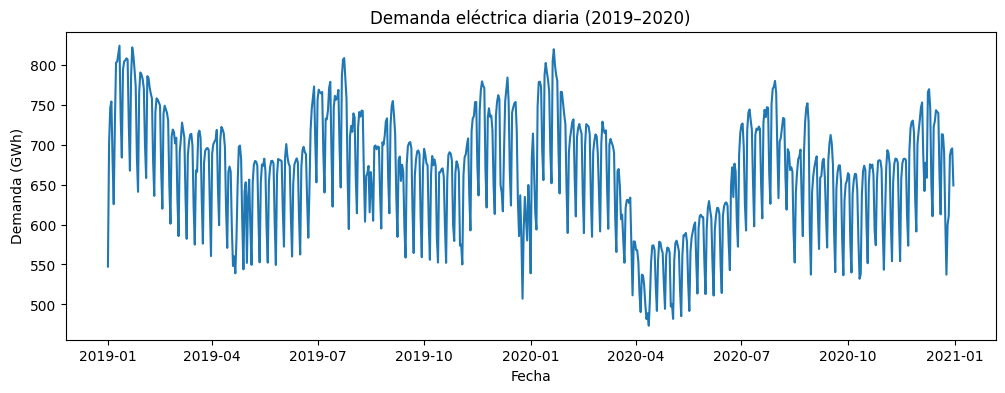

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(df_prophet["ds"], df_prophet["y"])
plt.title("Demanda eléctrica diaria (2019–2020)")
plt.xlabel("Fecha")
plt.ylabel("Demanda (GWh)")
plt.show()

### Descomposición de la serie temporal

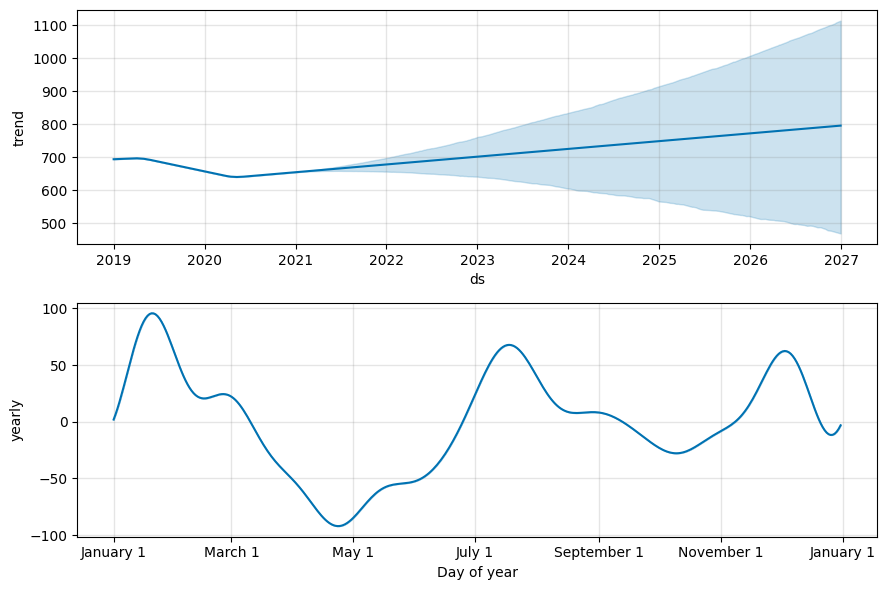

In [ ]:
model_prophet.plot_components(forecast)
plt.show()

### Validación del modelo (2023)

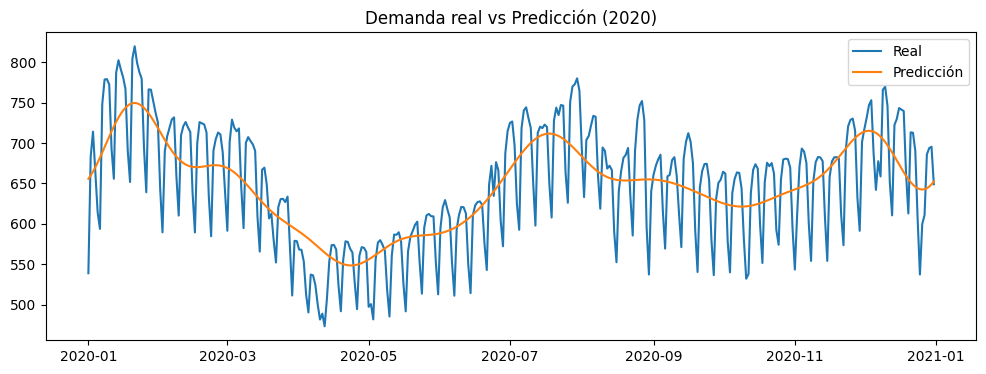

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(real_2020["ds"], real_2020["y"], label="Real")
plt.plot(pred_2020["ds"], pred_2020["yhat"], label="Predicción")
plt.legend()
plt.title("Demanda real vs Predicción (2020)")
plt.show()

### Proyección de la demanda eléctrica (2024–2026)

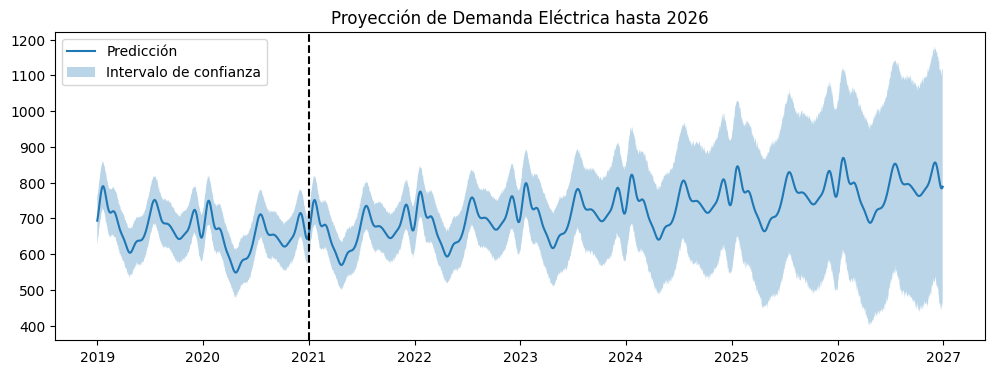

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(forecast["ds"], forecast["yhat"], label="Predicción")
plt.fill_between(
    forecast["ds"],
    forecast["yhat_lower"],
    forecast["yhat_upper"],
    alpha=0.3,
    label="Intervalo de confianza"
)
plt.axvline(pd.to_datetime("2020-12-31"), linestyle="--", color="black")
plt.legend()
plt.title("Proyección de Demanda Eléctrica hasta 2026")
plt.show()

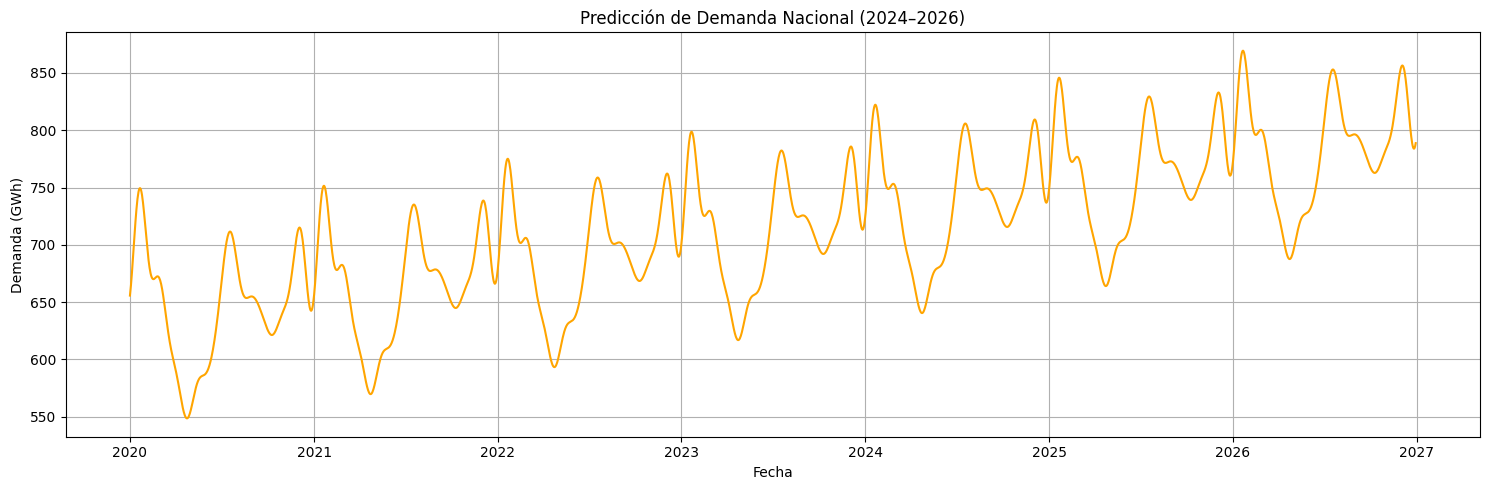

In [ ]:
# --- Subconjunto futuro 2024-2026 ---
pred_3y = forecast[
    (forecast["ds"] >= "2020-01-01") &
    (forecast["ds"] <= "2026-12-31")
].copy()

# --- Gráfico ---
plt.figure(figsize=(15, 5))
plt.plot(pred_3y["ds"], pred_3y["yhat"], label="Predicción 2020–2026", color="orange")
plt.title("Predicción de Demanda Nacional (2020–2026)")
plt.xlabel("Fecha")
plt.ylabel("Demanda (GWh)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Filtrar el DataFrame 'forecast_all' para el rango de fechas deseado
export_df = forecast[
    (forecast['ds'] >= '2024-01-01') &
    (forecast['ds'] <= '2026-12-31')
].copy() # Usar .copy() para evitar SettingWithCopyWarning

# Extraer Year, Month, Day de la columna 'ds'
export_df['Year'] = export_df['ds'].dt.year
export_df['Month'] = export_df['ds'].dt.month
export_df['Day'] = export_df['ds'].dt.day

# Seleccionar las columnas relevantes y reordenarlas
export_df = export_df[['Year', 'Month', 'Day', 'yhat', 'yhat_lower', 'yhat_upper']]

# Renombrar columnas para mayor claridad en el Excel
export_df.rename(columns={
    'yhat': 'Demanda_Predicha_GWh',
    'yhat_lower': 'Limite_Inferior_GWh',
    'yhat_upper': 'Limite_Superior_GWh'
}, inplace=True)

# Definir el nombre del archivo de Excel
excel_filename = 'prediccion_demanda_2024_2026.xlsx'

# Exportar a Excel
export_df.to_excel(excel_filename, index=False)

¡Datos de predicción exportados exitosamente a 'prediccion_demanda_2024_2026.xlsx' con columnas de Año, Mes y Día!
